**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


__Test Cases:__

1. Try ideal scenario: KW = Identity matrix, A = 0, B = 0
2. Limit number of neurons to 2
3. Test SGD against simple cost function ($y = x^2$)
4. Ideal scenario with A/B: KW = I, A - Kb = 0

In [1]:
import numpy as np
from numpy import linalg, matlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set()


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.zeros( (np.size(lambda_vect, 0), 1) )
    newFR[:, 0] = np.matmul(lambda_vect, targ_vect_mult)
    return newFR

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# brainFiringRate(lambda_vect, targ_vect) = b + Wt
#********


###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1  
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N
    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# gamma = 0.5
# delta_perturb = np.array([[4], [5], [6], [7]])
# calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect) = lambda_vect - (gamma*error grad*[1 tx ty])
#********

### Decoder Model

In [3]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, brain_params):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    (fr_curr, targ) = brain_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = np.zeros( (NUM_DIM, 1))
    cursor_pos = a_vect.reshape(NUM_DIM, 1) +  (np.matmul(k_matx, fr_curr))
    return (cursor_pos)

#********
# Passed Test: 
# a = np.array([-10, -20])
# k = np.random.random([2, 4])
# NUM_DIM = 2
# fr = brainFiringRate(lambda_vect, targ_vect)
# decoder_params = (a, k)
# brain_params = (fr, targ_vect)
# pos = decoder_findY(decoder_params, brain_params) = a + Kf
#********

ADAPT_DEC = True

# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, brain_vars):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), brain_vars)
    # a vector
    if (ADAPT_DEC == True):
        a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist, error_costFunc, cost_func_args)
        k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, error_costFunc, cost_func_args)
        a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx.copy() - k_rate*k_grad
    else:
        a_next = a_vect
        k_next = k_matx

    return (a_next, k_next)

#*******
# TODO: Test this function
#*******

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# this returns the square of distance between the two position points
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect).reshape(NUM_DIM,1) - np.array(t_vect).reshape(NUM_DIM, 1)
    return (np.linalg.norm(norm_vect, 2)**2)

#*******
# Failed test:
# Had to add .reshape(NUM_DIM, 1) to the norm vect
# Update:
# Passed Test
#*******

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect) = brain_vars
    y_vect = decoder_findY(decoder_params, brain_vars)
    t_vect = targ_vect
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
import random
import time


## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, (curr_fr, targ_vect) ) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.random.uniform(-sigma, sigma, [num_input_row, num_input_column, num_dist])
    

# Normalizes the stochastic perturbations to 1 and then multiplies by sigma, so perturb_rand = +/- sigma
#     perturb_rand /= np.linalg.norm(perturb_rand,axis=1)[:,np.newaxis]
#     perturb_rand *= sigma

    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, (input_perturb, targ_vect) ) 
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

#     error_grad = np.array(error_sum/(num_dist*delta*(sigma**2)))
    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad

### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# Old code

# # This function goes through and updates brain paramters over the num_iter times
# def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
#     (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_init, targ_vect)= brain_vars
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
#     (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
#     decoder_init = (a_init, k_init)
#     grad_args_init = (decoder_init, brain_vars)
    

#     num_neurons = np.size(fr_init, 0)
#     runs_num = 1

#     # for sigma in sigma_list:
#     for iR in range(runs_num):
#         # Set the u vectors
#         fr_vect = np.zeros( (num_neurons, 1, num_iter) )
#         fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
# #         fr_vect[:, 0] = fr_init
#         fr_final = np.zeros((num_neurons, 1, runs_num))
#         re_final = np.zeros(runs_num)
#         lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

#         print("starting fr vect = " + str( fr_vect[:, :, 0] ))
#         # lambda init = N x 3
#         # lambda_vect = N x 3 X ITER
#         lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
#         lambda_vect[:,:,0] = lambda_init 

#         # set the cost vector
#         err_vect = np.zeros(num_iter)
#         err_vect[0] = error_costFunc(grad_args_init)
#         print('initial error = ' + str(err_vect[0]))

#         # calculate the initial delta e
#         grad_new = np.zeros(num_iter)
#         grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

#         for iT in range(num_iter-1):
#             ## calculate the new u 
#             # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
#             lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
#             lambda_vect[:,:, iT + 1] = lambda_next
            
#             # (2) fr+ = B(lambda+)
#             fr_next = brainFiringRate(lambda_next, targ_vect)
#             fr_vect[:, :, iT+1] = fr_next

#             # Update parameters for calculating error and calculate the new cost
#             # (3) Calculate the new reach error 
#             brain_vars_next = fr_next, targ_vect
#             grad_args_next = (decoder_init, brain_vars_next)
#             err_next = np.array(error_costFunc(grad_args_next))
#             err_vect[iT+1] = err_next

#             # (4) calculate the next error descent term to update FR again
#             grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
#         fr_final[:, :, iR] = fr_next
#         re_final[iR] = err_next
#         lambda_final[:, :, iR] = lambda_next        

#     return (re_final, fr_final, lambda_final)


In [7]:
# This function goes through and updates brain paramters over the num_iter times
def calcNextBrain(brain_params, decoder_params, targ_vect, num_iter):
    # Unpack arguments that are being passed in
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    decoder_vals = (a_vect, k_matx)
#     grad_args_init = (decoder_vals, fr_init)
    
    num_neurons = np.size(fr_init, 0)
    fr_vect = np.zeros( (num_neurons, 1, num_iter) )
    fr_final = np.zeros( np.size(fr_init) )
    fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
    
    # lambda init = N x 3
    # lambda_vect = N x 3 X ITER
    lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
    lambda_vect[:, :, 0] = lambda_init 
    lambda_final = np.zeros(np.size(lambda_init))
    
    for iT in range(num_iter-1):
        # (1) calculate the perturbation
        brain_vars = (fr_vect[:, :, iT], targ_vect)
        grad_args = (decoder_vals, brain_vars)
        grad_new = findErrorGrad(fr_vect[:, :, iT], FR_VAR, fr_dist, error_costFunc, grad_args)
       
        # (2) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
        lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
        lambda_vect[:,:, iT + 1] = lambda_next
       
        # (2) fr+ = B(lambda+)
        fr_next = brainFiringRate(lambda_next, targ_vect)
        fr_vect[:, :, iT + 1] = fr_next
       
    lambda_final = lambda_next
    fr_final = fr_next

    return  (fr_final, lambda_final)

### Generate New Trial

In [8]:
def findNextTarget(curr_cursor, prev_targ):
    ## random
    x_pos = int(np.random.random_sample()*10)
    y_pos = int(np.random.random_sample()*10)

    return np.array( [x_pos, y_pos] )

### Set initial conditions

In [9]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = 1 x N
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

NUM_NEURONS = 10
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

print("INITIAL CONDITIONS")
print("NUM NEURONS = " + str(NUM_NEURONS))
# target position
TARGET_VECTOR = np.array([[1] , [1]])
# TARGET_VECTOR = np.array([[1]])
print(np.shape(TARGET_VECTOR))
print("initial target = " + str(TARGET_VECTOR))

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 

# BASELINE (b)
BASELINE = (10*np.random.random_sample(NUM_NEURONS))  # random float [0, 10)
print("baseline shape = " + str(np.shape(BASELINE)))
print("b =" + str(BASELINE))

# decoder initial paramters
# IDEAL: y = a + Kf = a + K(b + Wt) = a + Kb + KWt
# in order for y = t, want: a + Kb --> 0 and KW --> Identity matx
K_MATX = np.random.random_sample( (NUM_DIM, NUM_NEURONS) ) # random float [0, 1)
# A_VECT = (-np.matmul(K_MATX, BASELINE))
A_VECT = -np.random.random_sample( (NUM_DIM) )
print("K MATX = " + str(K_MATX))
print("A = " + str(A_VECT))

KW_only = False #False = include A/B, True = only K/W, no baseline
BRAIN_ADAPT = True

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
W_init = np.linalg.pinv(K_MATX) 
W_rand = 3*np.random.random_sample( (NUM_NEURONS, NUM_DIM) )
W_init = W_init + W_rand
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1:3] = W_init
print("lambda init = ")
print(lambda_init)


# lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
# lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# # lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# # lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_

# SGD initial parameters
# Mapping for variables
FR_VAR = 1
A_VAR = 2
K_VAR = 3

# Brain
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
# A_RATE = 1e-4
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
# K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 10
fig_y = 5



INITIAL CONDITIONS
NUM NEURONS = 10
(2, 1)
initial target = [[1]
 [1]]
baseline shape = (10,)
b =[9.03047516 8.0785758  6.65665011 2.42310706 6.5653373  9.32088345
 6.03122204 1.76155694 6.99155268 5.3689772 ]
K MATX = [[0.33836988 0.29791317 0.54220155 0.8683926  0.59341196 0.51697342
  0.07889436 0.8193274  0.77390707 0.02699203]
 [0.06682037 0.86848593 0.84647412 0.31600125 0.80999073 0.7858904
  0.36359553 0.39336861 0.38747726 0.88477217]]
A = [-0.62679852 -0.27201468]
lambda init = 
[[ 9.03047516  2.69273724 -0.056987  ]
 [ 8.0785758   2.28075285  1.7731552 ]
 [ 6.65665011  0.06229324  0.59703539]
 [ 2.42310706  2.54134939  0.72749494]
 [ 6.5653373   0.72180806  2.25379891]
 [ 9.32088345  1.51208443  0.69762246]
 [ 6.03122204  1.80077174  1.335988  ]
 [ 1.76155694  1.01020873  0.23043073]
 [ 6.99155268  2.13619013  2.40953235]
 [ 5.3689772   1.38860982  1.64421885]]


### Adaptive Decoder

In [29]:
NUM_TRIALS = 50
NUM_RUNS = 2 # Has to be >1 # 2 = goes through the trial for target once
NUM_SESSIONS = 3
# rate_list = [5e-3, 1e-3, 5e-4, 1e-4]
rate_list = [5e-4]
A_RATE = 1e-4
K_RATE = 1e-4
ADAPT_TRIALS = NUM_TRIALS

# initialization
cursor_start = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
cursor_end = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
target_trial = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS, NUM_SESSIONS) )
fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
a_trial = np.zeros( (NUM_DIM, NUM_TRIALS, NUM_SESSIONS) )
k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS, NUM_SESSIONS) )
re_startT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
re_endT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )


print("=========================================")
print("EXPERIMENT DETAILS")
print("=========================================")
print("Adaptive Decoder = " + str(ADAPT_DEC))
print("Adaptive Brain = " + str(BRAIN_ADAPT))
print("Total Number of Trials = " + str(NUM_SESSIONS))
print("Total Number of Sessions = " + str(NUM_SESSIONS))
print("Brain Learning Rate = " + str(rate_list))
print("Decoder (K) Learning Rate = " + str(K_RATE))
print("Decoder (A) Learning Rate = " + str(A_RATE))
print("=========================================")

EXPERIMENT DETAILS
Adaptive Decoder = True
Adaptive Brain = True
Total Number of Trials = 3
Total Number of Sessions = 3
Brain Learning Rate = [0.0005]
Decoder (K) Learning Rate = 0.0001
Decoder (A) Learning Rate = 0.0001



+++++++++++++++++++++++++++++++++++
Session #0
Session Start
target at trial 0 = [[1.]
 [1.]]
K MATX INIT = 
[[0.33836988 0.29791317 0.54220155 0.8683926  0.59341196 0.51697342
  0.07889436 0.8193274  0.77390707 0.02699203]
 [0.06682037 0.86848593 0.84647412 0.31600125 0.80999073 0.7858904
  0.36359553 0.39336861 0.38747726 0.88477217]]
A VECT INIT = 
[-0.62679852 -0.27201468]
LAMBDA INIT = 
[[ 9.03047516  2.69273724 -0.056987  ]
 [ 8.0785758   2.28075285  1.7731552 ]
 [ 6.65665011  0.06229324  0.59703539]
 [ 2.42310706  2.54134939  0.72749494]
 [ 6.5653373   0.72180806  2.25379891]
 [ 9.32088345  1.51208443  0.69762246]
 [ 6.03122204  1.80077174  1.335988  ]
 [ 1.76155694  1.01020873  0.23043073]
 [ 6.99155268  2.13619013  2.40953235]
 [ 5.3689772   1.38860982  1.64421885]]

--------------------
Session End
Session #0
K MATX END= 
[[ 0.07304427 -0.1495831   0.26333396  0.36888205  0.13647988  0.12554
  -0.33742631  0.79044126  0.19133571 -0.20448038]
 [-0.49792594  0.14598812  0.6933

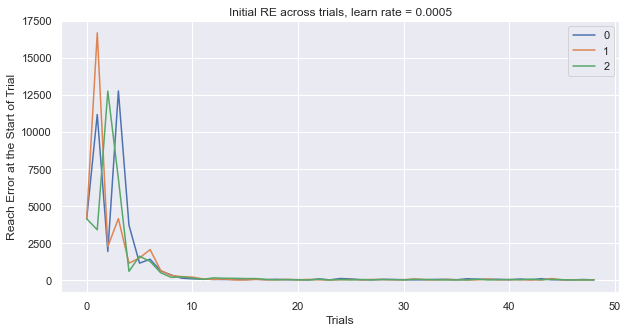

In [35]:
for lambda_rate in rate_list:
    for iS in range(NUM_SESSIONS):
        print("")
        print("+++++++++++++++++++++++++++++++++++")
        print("Session #" + str(iS))
        print("Session Start")
        ## BRAIN SIDE
        FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
    #     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))

        ## DECODER SIDE
        A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
        K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)

        # target position -- new target represents a new trial
        target_trial[:, :, 0, iS] = TARGET_VECTOR
        print("target at trial 0 = " + str(target_trial[:, :, 0, iS]))

        print("K MATX INIT = ")
        print(K_MATX)
        print("A VECT INIT = ")
        print(A_VECT)

        ## VECTORS FOR TRIALS    
        lambda_trial[:, :, 0, iS] = lambda_init
        print("LAMBDA INIT = ")
        print(lambda_trial[:, :, 0, iS])

        a_trial[:, 0, iS] = np.array(A_VECT)
#         print("a")
#         print(a_trial[:, 0, iS])

        k_trial[:,:, 0, iS] = K_MATX
#         print("K")
#         print(k_trial[:,:, 0, iS] )
        decoder_params = (a_trial[:, 0, iS], A_RATE, A_DIST, k_trial[:,:,  0, iS], K_RATE, K_DIST)
        decoder_vals = (A_VECT, K_MATX)
        

        for iT in range(NUM_TRIALS-1):
#             print("")
#             print("=========================================")
#             print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
#             print("Target = " + str(target_trial[:, :, iT, iS]))

            # calculate firing rate given lambda and decoder parameters with current target position 
            fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT, iS], target_trial[:, :, iT, iS]))
            fr_trial[:, :, iT] = fr_start
            
#             print("lambda start of trial = " + str(lambda_trial[:, :, iT, iS]))
            # calculate reach error of firing rate at the beginning of the trial
            # this becomes the error of the new target position being presented and where the cursor is
            brain_vars = ( fr_trial[:, :, iT],  target_trial[:, :, iT, iS] )
            cost_func_params = (decoder_vals, brain_vars) 
            
            re_startT[iT, iS] = error_costFunc(cost_func_params)

    #         (a_vect_in, k_matx_in) = decoder_params
            cursor_start[ :, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
#             print("cursor start = " + str(cursor_start[:, :, iT, iS]) )
#             print("decoder vals start = " + str(decoder_vals))

            # Run through trial and see the reach at the end        
            # current brain and decoder params
            brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT, iS], lambda_rate)
            decoder_params = (a_trial[:, iT, iS], A_RATE, A_DIST, k_trial[:, :,  iT, iS], K_RATE, K_DIST)

            # adapt brain and decoder (together here)
            a_run, k_run = calcNextDecoder(decoder_params, brain_vars)
            if (KW_only):
                a_run = np.zeros((2, 1))
                
            if (BRAIN_ADAPT):
                fr_run, lambda_run = calcNextBrain(brain_params, decoder_params, target_trial[:, :, iT, iS], NUM_RUNS)
            else:
                fr_run = fr_trial[:, :, iT]
                lambda_run = lambda_trial[:, :, iT, iS]
            
            # update cost function arguments
            decoder_vals = (a_run, k_run)
            brain_vars = (fr_run, target_trial[:, :, iT, iS])
            # see how the updated decoder and brain paramters have done with the current
            # target position (so target at trial = iT)
            cost_func_params = (decoder_vals, brain_vars) 
            re_run = np.array(error_costFunc(cost_func_params))

            # So what are the end trial metrics?
            if (KW_only):
                lambda_run[:, 0] = 0
            cursor_end[:, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
#             print("fr end of trial = " + str(fr_run))
#             print("lambda end of trial = " + str(lambda_run))
#             print("cursor end = " + str(cursor_end[:, :, iT, iS]) )

            re_endT[iT, iS] = re_run
#             print("re end = " + str(re_endT[iT, iS]))
#             print("re diff = " + str(re_endT[iT, iS] - re_startT[iT, iS]))

            # update the parameters
            lambda_trial[:, :, iT + 1, iS] = np.squeeze(lambda_run)
        
            a_trial[:, iT + 1, iS] = np.squeeze(a_run)
            k_trial[:, :, iT + 1, iS] = np.squeeze(k_run)
#             print("a = " + str(a_trial[:, iT + 1, iS]))
#             print("k = " + str(k_trial[:, :, iT + 1, iS]))

            # change to new target
            target_trial[:, 0, iT + 1, iS] = findNextTarget( cursor_end[:, :, iT, iS], target_trial[:, :, iT, iS] )
    
        print("")
        print("--------------------")
        print("Session End")
        print("Session #" + str(iS))
        print("K MATX END= ")
        print((k_trial[:, :, NUM_TRIALS-1, iS]))
        print("A VECT END = ")
        print(a_trial[:, NUM_TRIALS-1, iS])
        print("LAMBDA END = ")
        print(lambda_trial[:, :, NUM_TRIALS-1, iS])

        
        
        pidx = rate_list.index(lambda_rate)
        plt.figure(2*pidx + 1, figsize=(fig_x, fig_y))
        plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_startT[0:len(re_startT)-1, iS], label = '' + str(iS))
        plt.legend()
        plt.xlabel('Trials')
        plt.ylabel('Reach Error at the Start of Trial')
        plt.title('Initial RE across trials, learn rate = ' + str(lambda_rate))


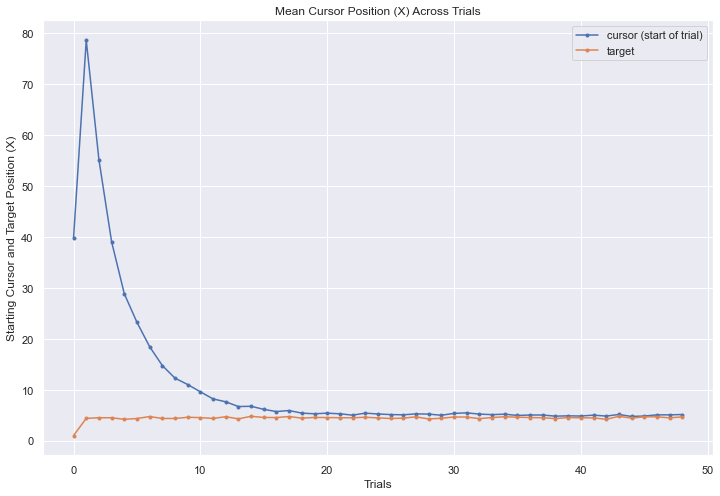

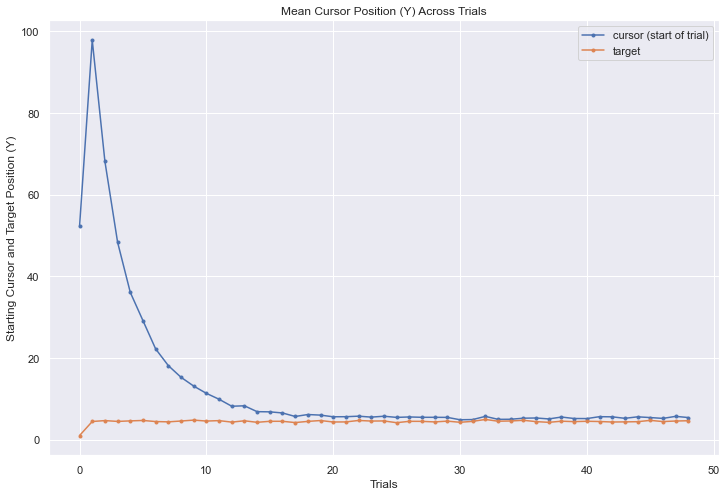

In [11]:
x = 0
y = 1

plt.figure(figsize = (12, 8))
start_x_mean = np.mean(cursor_start, axis=3)[x, 0, 0:NUM_TRIALS-1]
end_x_mean = np.mean(cursor_end, axis=3)[x, 0, 0:NUM_TRIALS-1]
start_y_mean = np.mean(cursor_start, axis=3)[y, 0, 0:NUM_TRIALS-1]
end_y_mean = np.mean(cursor_end, axis=3)[y, 0, 0:NUM_TRIALS-1]
targ_x_mean = np.mean(target_trial, axis=3)[x, 0, 0:NUM_TRIALS-1]
targ_y_mean = np.mean(target_trial, axis=3)[y, 0, 0:NUM_TRIALS-1]

plt.plot(start_x_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (X)')
plt.title('Mean Cursor Position (X) Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_x_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (X)')
# plt.title('Cursor Position Across Trials')
# plt.show()

plt.figure(figsize = (12, 8))
plt.plot(start_y_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (Y)')
plt.title('Mean Cursor Position (Y) Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_y_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (Y)')
# plt.title('Cursor Position Across Trials')
# plt.show()

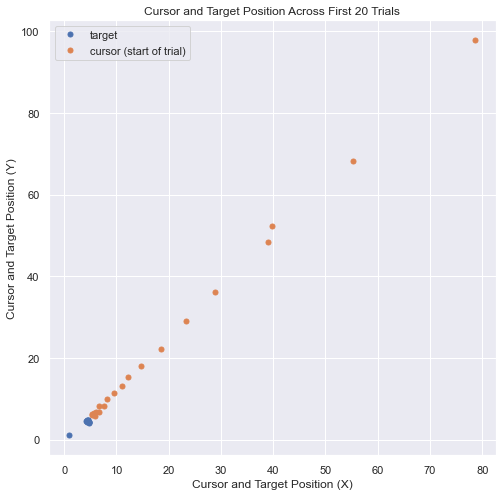

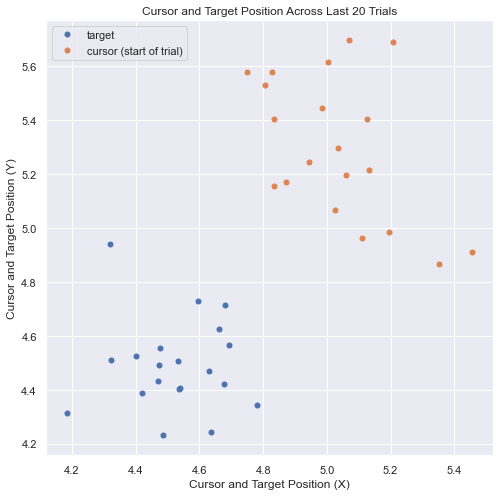

In [12]:
show_num = 20
plt.figure(figsize = (8, 8))
plt.plot(targ_x_mean[0:show_num], targ_y_mean[0:show_num], linestyle = '', marker = '.', markersize = 10, label = 'target' )
plt.plot(start_x_mean[0:show_num], start_y_mean[0:show_num], linestyle = '', marker = '.', markersize = 10, label = 'cursor (start of trial)')
plt.legend()
plt.xlabel('Cursor and Target Position (X)')
plt.ylabel('Cursor and Target Position (Y)')
plt.title('Cursor and Target Position Across First 20 Trials')
plt.show()

plt.figure(figsize = (8, 8))
plt.plot(targ_x_mean[-show_num:], targ_y_mean[-show_num:], linestyle = '', marker = '.', markersize = 10, label = 'target' )
plt.plot(start_x_mean[-show_num:], start_y_mean[-show_num:], linestyle = '', marker = '.', markersize = 10, label = 'cursor (start of trial)')
plt.legend()
plt.xlabel('Cursor and Target Position (X)')
plt.ylabel('Cursor and Target Position (Y)')
plt.title('Cursor and Target Position Across Last 20 Trials')
plt.show()


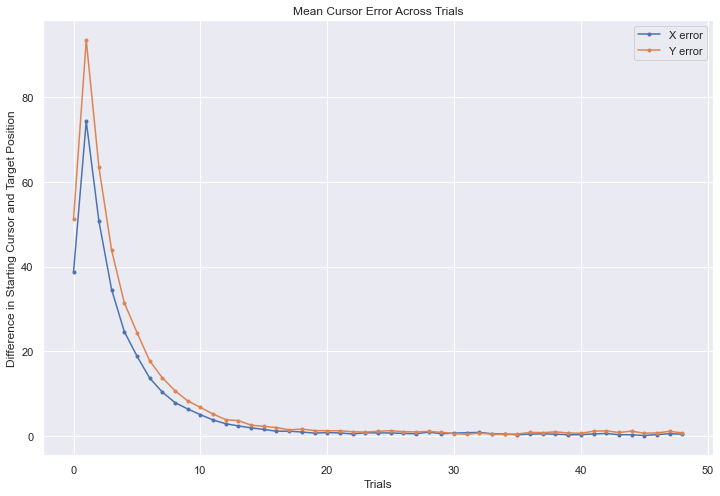

In [13]:
plt.figure(figsize = (12, 8))
plt.plot(start_x_mean - targ_x_mean, linestyle = '-', marker = '.', label = 'X error')
plt.plot(start_y_mean - targ_y_mean, linestyle = '-', marker = '.', label = 'Y error' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Difference in Starting Cursor and Target Position')
plt.title('Mean Cursor Error Across Trials')
plt.show()

Text(0.5, 1.0, 'Mean KW Matrix (1,1)')

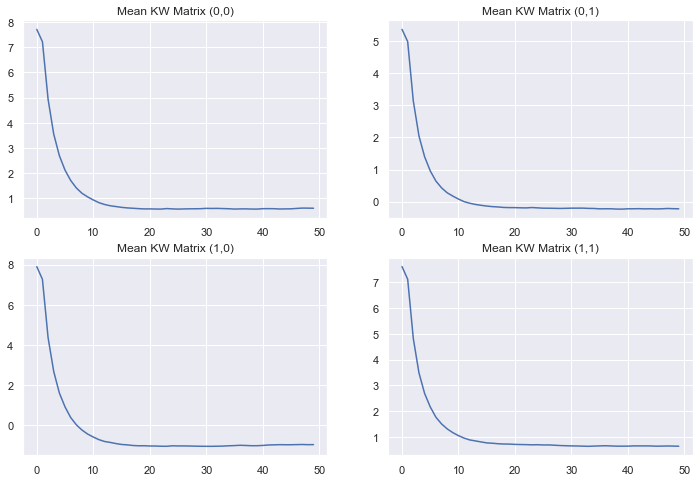

In [14]:
# print(np.shape(lambda_trial))
# print(np.shape(k_trial))
# print(np.shape((k_trial[:, :,1])))
# print(np.shape((lambda_trial[:, 1:3, 1])))

lk_mtx = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS))
lk_mtx_temp = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS, NUM_SESSIONS))
# print(np.shape((k_trial[:,:, :, 1])))
# print((lambda_trial[:, 1:3, 1, 1]))
for iT in range(NUM_TRIALS):
    for iS in range(NUM_SESSIONS):
        lk_mtx_temp[:,:, iT, iS] = np.matmul(k_trial[:,:, iT, iS], lambda_trial[:, 1:3, iT, iS])
    lk_mtx = np.mean(lk_mtx_temp[:,:, :, :], axis=3)

 
plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, :])
plt.title("Mean KW Matrix (0,0)")

plt.subplot(222)
plt.plot(lk_mtx[0, 1, :])
plt.title("Mean KW Matrix (0,1)")

plt.subplot(223)
plt.plot(lk_mtx[1, 0, :])
plt.title("Mean KW Matrix (1,0)")

plt.subplot(224)
plt.plot(lk_mtx[1, 1, :])
plt.title("Mean KW Matrix (1,1)")


Text(0.5, 1.0, 'Mean KW Matrix (1,1) | Last 100 Trials ')

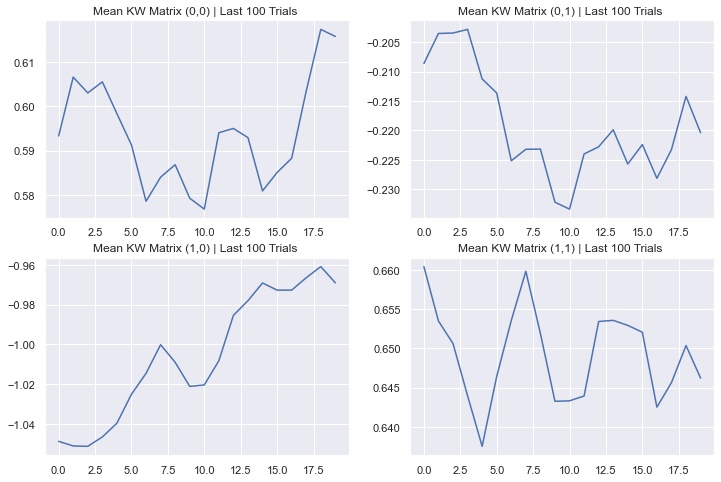

In [19]:
last = 20

plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,0) | Last 100 Trials ")

plt.subplot(222)
plt.plot(lk_mtx[0, 1,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,1) | Last 100 Trials ")


plt.subplot(223)
plt.plot(lk_mtx[1, 0,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,0) | Last 100 Trials ")

plt.subplot(224)
plt.plot(lk_mtx[1, 1,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,1) | Last 100 Trials ")


In [16]:
print("Average Reach Error Per Session:")

for iS in range(NUM_SESSIONS):
    print("Session # " + str(iS) + "| RE = " + str(np.mean(re_startT[:, iS])))

Average Reach Error Per Session:
Session # 0| RE = 852.7886381199446
Session # 1| RE = 822.5113924102859
Session # 2| RE = 723.252443942022
Session # 3| RE = 732.6583598323475
Session # 4| RE = 822.1497680738244
Session # 5| RE = 832.9827325036748
Session # 6| RE = 779.9138848259469
Session # 7| RE = 682.8217951048795
Session # 8| RE = 771.8429101096409
Session # 9| RE = 731.3953799106674
Session # 10| RE = 781.2173702354944
Session # 11| RE = 838.5000492180765
Session # 12| RE = 760.1501618917226
Session # 13| RE = 683.3808815818026
Session # 14| RE = 737.0152936667129
Session # 15| RE = 748.0836353255086
Session # 16| RE = 757.2371741360818
Session # 17| RE = 694.4175818577099
Session # 18| RE = 725.3649793639145
Session # 19| RE = 807.0532808129868
Session # 20| RE = 739.2785767267197
Session # 21| RE = 800.3282979358784
Session # 22| RE = 759.5435029567872
Session # 23| RE = 786.3259248298451
Session # 24| RE = 740.5278884034428
Session # 25| RE = 725.3091220458379
Session # 26| RE

In [17]:
# TODO Here:
# print the K matrix across time
# print lambda matrix across time for quick check of adapting


print(np.shape((k_trial)))
print(np.shape(lambda_trial))


(2, 10, 50, 300)
(10, 3, 50, 300)


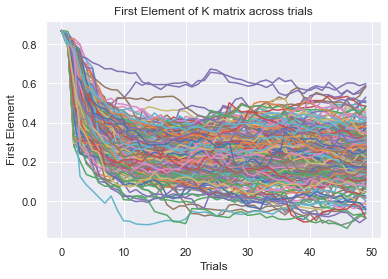

Text(0, 0.5, 'First Element')

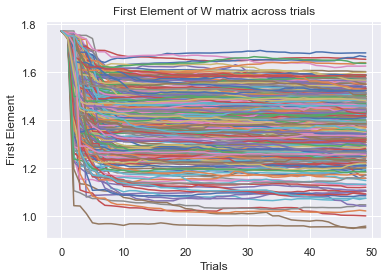

In [21]:
# plot of 1st dimension, neuron #1 and 1st session 

for iS in range(NUM_SESSIONS):
    plt.plot(k_trial[1, 1,:, iS]) #, label=''+sr(iS))
plt.title("First Element of K matrix across trials")
plt.xlabel("Trials")
plt.ylabel("First Element")
plt.show()

for iS in range(NUM_SESSIONS):
    plt.plot(lambda_trial[1, 2,:, iS]) #, label=''+str(iS))
plt.title("First Element of W matrix across trials")
plt.xlabel("Trials")
plt.ylabel("First Element")
# plt.legend()

In [23]:
print("=========================================")
print("EXPERIMENT DETAILS")
print("=========================================")
print("Adaptive Decoder = " + str(ADAPT_DEC))
print("Adaptive Brain = " + str(BRAIN_ADAPT))
print("Total Number of Trials = " + str(NUM_TRIALS))
print("Total Number of Sessions = " + str(NUM_SESSIONS))
print("Brain Learning Rate = " + str(rate_list))
print("Decoder (K) Learning Rate = " + str(K_RATE))
print("Decoder (A) Learning Rate = " + str(A_RATE))

EXPERIMENT DETAILS
Adaptive Decoder = True
Adaptive Brain = True
Total Number of Trials = 50
Total Number of Sessions = 300
Brain Learning Rate = [0.0005]
Decoder (K) Learning Rate = 0.0001
Decoder (A) Learning Rate = 0.0001


In [28]:
print("Session End")
print("Session #" + str(iS))
print("K MATX END= ")
print((k_trial[:, :, NUM_TRIALS-1, iS]))
print("A VECT END = ")
print(a_trial[:, NUM_TRIALS-1, iS])
print("LAMBDA END = ")
print(lambda_trial[:, :, NUM_TRIALS-1, iS])

Session End
Session #299
K MATX END= 
[[-0.12676572 -0.15619527  0.25523958  0.73962686  0.08230342  0.05398325
  -0.41166659  0.81902198  0.24176428 -0.31487403]
 [-0.48774917  0.41604912  0.54554033 -0.07808272  0.37197031  0.21026014
  -0.05235671  0.33018381 -0.28961635  0.40607538]]
A VECT END = 
[-0.64766932 -0.30468564]
LAMBDA END = 
[[ 9.04383498  2.77264018 -0.02202172]
 [ 7.96434684  2.02374053  1.35756443]
 [ 6.50595715 -0.3979107   0.11125396]
 [ 2.30879776  2.15737005  0.29644491]
 [ 6.41797673  0.30208118  1.62808102]
 [ 9.19545143  1.22106197  0.20956221]
 [ 6.01042263  1.75408353  1.24675422]
 [ 1.62203167  0.61538078 -0.22330945]
 [ 6.95119311  2.09650923  2.29664914]
 [ 5.25365016  1.09333149  1.1168163 ]]
